In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from datetime import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from torch.autograd import Variable

import torch.nn as nn
import torch

from CanonicalComponentCCA import CanonicalComponent
from WitnessFunction import WitnessFunction
from Generate_synthetic import GenerateData
from sklearn.manifold import TSNE

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [4]:
from types import SimpleNamespace
opt = {
    "n_epochs": 100,
    "batch_size": 1000,
    "alpha": 0.009,
    "beta": 8e-5,
    "latent_dim": 1,
    "n_critic": 1,
    "lsmooth": 1
}
opt = SimpleNamespace(**opt)

In [5]:
visualize_dim = 5000

In [6]:
def run_simulations(signal_property, noise_property, data_dimensions, anchor_nums=0, random_seed=33333):
    #Generate data
    torch.manual_seed(random_seed)
    
    # lambdaa = 0.1  #1.2, 0.05, 1e-2 for old f_theta
    
    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    
    data_generate = GenerateData(data_dimensions, opt.batch_size)
    
    mixer_property = {"mean": 0, "std": 1, "dist": "normal"}
    X_1, X_2, S, scir, C1, C2 = data_generate.generate_cca_data(signal_property, noise_property, mixer_property, normalize_mean=True)
    
    if data_dimensions["D"] >= 3:
        display_type = 3
    else:
        display_type = data_dimensions["D"]
    
    A1, A2 = data_generate.get_mixing_matrices()
    A1 = A1.type(Tensor)
    A2 = A2.type(Tensor)
    print("Conditions number of mixing matrices: ", torch.linalg.cond(A1), torch.linalg.cond(A2))
    
    X_1 = Variable(X_1.type(Tensor))
    X_2 = Variable(X_2.type(Tensor))
    S = Variable(S.type(Tensor))
    
    view1, view2 = data_generate.create_dataloader(X_1, X_2)
    
    z1 = CanonicalComponent(X_1, data_dimensions["D"], data_dimensions["M1"], data_dimensions["N"], Tensor)
    z2 = CanonicalComponent(X_2, data_dimensions["D"], data_dimensions["M2"], data_dimensions["N"], Tensor)
    f = WitnessFunction(data_dimensions["D"], opt.latent_dim)

    if anchor_nums>0:
        print("Multiple anchor points")
        random_indices = np.random.choice(X_1.shape[1], size=anchor_nums, replace=False)
        anchors1 = X_1[:, random_indices]
        anchors2 = X_2[:, random_indices]
    else:
        anc_loss = torch.tensor([0.0]).type(Tensor)
        anchors1 = []
        anchors2 = []
    
    if cuda:
        z1.cuda()
        z2.cuda()
        f.cuda()
    
    # Optimizers
    alpha1 = opt.alpha
    alpha2 = opt.alpha
    beta = opt.beta
    optimizer_z1 = torch.optim.Adam(z1.parameters(), lr=alpha1)
    optimizer_z2 = torch.optim.Adam(z2.parameters(), lr=alpha2)
    optimizer_f = torch.optim.Adam(f.parameters(), lr=beta)
    
    lambdaa = 0.1  #1.2, 0.05, 1e-2 for old f_theta
    lambda_anc = 0.01
    
    n_epochs = data_dimensions["n_epochs"]
    batch_size = opt.batch_size
    lsmooth = 1
    loss_func = nn.BCELoss()
    
    n_critic = 1
    n_z1 = 1
    n_z2 = 1
    
    
    D = data_dimensions["D"]
    all_loss_f = []
    all_loss_z = []
    shared_component_dist = []
    for epoch in range(n_epochs-1):
        
        noise_factor = 1.0 - (epoch / n_epochs)
        avg_loss_z = []
        avg_loss_f = []
        avg_shared_dist = []
        for i, (X1, X2) in enumerate(zip(view1, view2)):
            
            ############################Distribution matching ################################
            labels_true = (torch.ones((batch_size, 1) )  - lsmooth * (torch.rand((batch_size, 1)) * 0.2 * noise_factor) ).type(Tensor) 
            labels_false = (torch.zeros((batch_size, 1) ) + lsmooth * (torch.rand((batch_size, 1) ) * 0.2 * noise_factor) ).type(Tensor)
    
            for _ in range(n_critic):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizer_f.zero_grad()
    
                # Select one generator to update
                s_1 = z1(X1).T
                s_2 = z2(X2).T
    
                # Discriminator loss
                loss_f = loss_func(f(s_1), labels_true) + loss_func(f(s_2), labels_false)
    
                loss_f.backward()
                optimizer_f.step()
    
             #######################################################################################
            for _ in range(n_z1):
                optimizer_z1.zero_grad()
    
                s_1 = z1(X1).T
                s_2 = z2(X2).T
    
                loss_fz1 = loss_func(f(s_1), labels_false)
                reg_z1 =   D * z1.id_loss()
                if anchor_nums > 0:
                    anc_loss = torch.norm(z1(anchors1.T) - z2(anchors2.T))**2
                loss_z1 = loss_fz1 + lambdaa * reg_z1 + lambda_anc * anc_loss
                
                loss_z1.backward()
                optimizer_z1.step()
            
            for _ in range(n_z2):
                optimizer_z2.zero_grad()
    
                s_1 = z1(X1).T
                s_2 = z2(X2).T
    
    
                loss_fz2 = loss_func(f(s_2), labels_true)
                reg_z2 =   D*z2.id_loss()
                if anchor_nums > 0:
                    anc_loss = torch.norm(z1(anchors1.T) - z2(anchors2.T))**2
                    
                loss_z2 = loss_fz2 + lambdaa * reg_z2 + lambda_anc * anc_loss
                
                loss_z2.backward()
                optimizer_z2.step()
            
            with torch.no_grad():
                loss_z = loss_fz1 + loss_fz2
                loss_reg = (reg_z1 + reg_z2)/D
                
                s_x = z1(X_1.T).T
                s_y = z2(X_2.T).T
                dist_loss = torch.norm(s_x-s_y)

                if anc_loss.item() > 1.5:
                    lambda_anc += lambda_anc
                    
                
            avg_loss_f.append( loss_f.item() )
            avg_loss_z.append( loss_z.item() )
            avg_shared_dist.append( dist_loss.item() )
            print(
                "[Epoch %d of %d]  [z1 loss: %f] [z2 loss: %f] [z loss: %f] [f loss: %f] [anc loss: %f] [reg loss : %f] [%f]" 
                % (epoch+1, i+1, loss_fz1.item(), loss_fz2.item(), loss_z.item(), loss_f.item(), anc_loss.item(), loss_reg.item(), dist_loss.item() )
            )
                
        
        all_loss_f.append(np.mean(avg_loss_f))
        all_loss_z.append(np.mean(avg_loss_z))
        shared_component_dist.append(np.mean(avg_shared_dist))
    return S, z1, z2, A1, A2, X_1, X_2, anchors1, anchors2, shared_component_dist

In [6]:
def find_plots(metadata):
    
    S, z1, z2, A1, A2, X_1, X_2, _, _, _ = metadata
    
    D = S.shape[0]
    
    q1 = z1.get_Q_value()
    q2 = z2.get_Q_value()
    theta_1 = (q1 @ A1).detach().cpu()
    theta_2 = (q2 @ A2).detach().cpu()

    print("Theta 1: ", theta_1)
    print("Theta 2: ", theta_2)
    
    if D > 2:
        print("Applying TSNE to shared components. Dimension greater than 2.")
        s_x = z1(X_1.T).T.detach()
        s_y = z2(X_2.T).T.detach()
        
        corig = S[:,:visualize_dim].T.cpu().numpy()
        c1 = s_x[:visualize_dim,].cpu().numpy()
        c2 = s_y[:visualize_dim,].cpu().numpy()

        tsne_shared = TSNE(n_components=2)
        tsne_c = tsne_shared.fit_transform(np.vstack( (corig,  c1, c2)  ))
        corig = tsne_c[:visualize_dim, ].T
        c1 = tsne_c[visualize_dim: 2*visualize_dim, ].T
        c2 = tsne_c[2*visualize_dim:, ].T
        
        print("Finished TSNE for shared components.")
        
        
    else:
        s_x = z1(X_1.T).T.detach()
        s_y = z2(X_2.T).T.detach()
        
        corig = S[:,:visualize_dim].cpu().numpy()
        c1 = s_x[:visualize_dim,].T.cpu().numpy()
        c2 = s_y[:visualize_dim,].T.cpu().numpy()
    

    tsne = TSNE(n_components=2)
    tsne_l = tsne.fit_transform(np.vstack( (X_1.T[:visualize_dim,].cpu().numpy(), X_2.T[:visualize_dim,].cpu().numpy()) ) )
    domain1 = tsne_l[:visualize_dim, ].T
    domain2 = tsne_l[visualize_dim:, ].T
    print("Finished applying TSNE")

    

    return corig, c1, c2, domain1, domain2

# Theorem 1 validations

In [8]:
#Dimensions intializations M_q>=D, M_q >= (D+D1)cca_loss
data_dimensions = {
    "N": 10**5, #Number of samples
    "D": 2, #shared component vector length
    "D1": 1, #Private component 1 vector length
    "D2": 1, #Private component 2 vector length
    "M1": 3, #(Number of rows)/(length of data) in actual data view1/ mixing matrix
    "M2": 3, #(Number of rows)/(length of data) in actual data view2/ mixing matrix
    "n_epochs":50
}

## Rectangular Support

In [9]:
signal_property_rec = {"mean": 2.5, "std": 2, "dist": "vonmises"} #these are parameters instead of mean and variance even though the variable is so
noise_property_rec = {"mean1": 1, "std1":3, "mean2": 0.5, "std2": 3, "dist1": "laplace", "dist2": "gamma"}

metadata_rec = run_simulations(signal_property_rec, noise_property_rec, data_dimensions)
corig_rec, c1_rec, c2_rec, domain1_rec, domain2_rec = find_plots(metadata_rec)

Generating mixing  matrix.
Shared Component to Interference Ratio: -3.341
Conditions number of mixing matrices:  tensor(5., device='cuda:0') tensor(5.0000, device='cuda:0')
[Epoch 1 of 1]  [z1 loss: 0.715350] [z2 loss: 0.682705] [z loss: 1.398055] [f loss: 1.388724] [anc loss: 0.000000] [reg loss : 555.046021] [7545.461914]
[Epoch 1 of 2]  [z1 loss: 0.731640] [z2 loss: 0.678674] [z loss: 1.410314] [f loss: 1.376314] [anc loss: 0.000000] [reg loss : 538.679077] [7441.673340]
[Epoch 1 of 3]  [z1 loss: 0.744247] [z2 loss: 0.674550] [z loss: 1.418797] [f loss: 1.368535] [anc loss: 0.000000] [reg loss : 522.591797] [7338.386230]
[Epoch 1 of 4]  [z1 loss: 0.757112] [z2 loss: 0.670484] [z loss: 1.427596] [f loss: 1.362220] [anc loss: 0.000000] [reg loss : 506.788574] [7235.643555]
[Epoch 1 of 5]  [z1 loss: 0.772363] [z2 loss: 0.668873] [z loss: 1.441236] [f loss: 1.355728] [anc loss: 0.000000] [reg loss : 491.273682] [7133.490723]
[Epoch 1 of 6]  [z1 loss: 0.783589] [z2 loss: 0.666723] [z los

## Independent content

In [10]:
signal_property_indep = {"mean": 1, "std": 2, "dist": ["mixture_diff_3", "gamma"]}#these are parameters instead of mean and variance even though the variable is so
noise_property_indep = {"mean1": 1, "std1":3, "mean2": 0.5, "std2": 3, "dist1": "laplace", "dist2": "uniform"}
metadata_indep = run_simulations(signal_property_indep, noise_property_indep, data_dimensions)
corig_indep, c1_indep, c2_indep, domain1_indep, domain2_indep = find_plots(metadata_indep)

Generating mixing  matrix.
Shared Component to Interference Ratio: -2.944
Conditions number of mixing matrices:  tensor(5.0000, device='cuda:0') tensor(5.0000, device='cuda:0')
[Epoch 1 of 1]  [z1 loss: 0.667521] [z2 loss: 0.727266] [z loss: 1.394787] [f loss: 1.399301] [anc loss: 0.000000] [reg loss : 756.613708] [8823.752930]
[Epoch 1 of 2]  [z1 loss: 0.662437] [z2 loss: 0.748362] [z loss: 1.410799] [f loss: 1.381002] [anc loss: 0.000000] [reg loss : 738.916870] [8729.970703]
[Epoch 1 of 3]  [z1 loss: 0.658724] [z2 loss: 0.767803] [z loss: 1.426528] [f loss: 1.368784] [anc loss: 0.000000] [reg loss : 721.538208] [8637.015625]
[Epoch 1 of 4]  [z1 loss: 0.653964] [z2 loss: 0.787607] [z loss: 1.441572] [f loss: 1.359268] [anc loss: 0.000000] [reg loss : 704.483154] [8544.933594]
[Epoch 1 of 5]  [z1 loss: 0.648948] [z2 loss: 0.810238] [z loss: 1.459186] [f loss: 1.348565] [anc loss: 0.000000] [reg loss : 687.756409] [8453.769531]
[Epoch 1 of 6]  [z1 loss: 0.644814] [z2 loss: 0.835634] [z

In [11]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


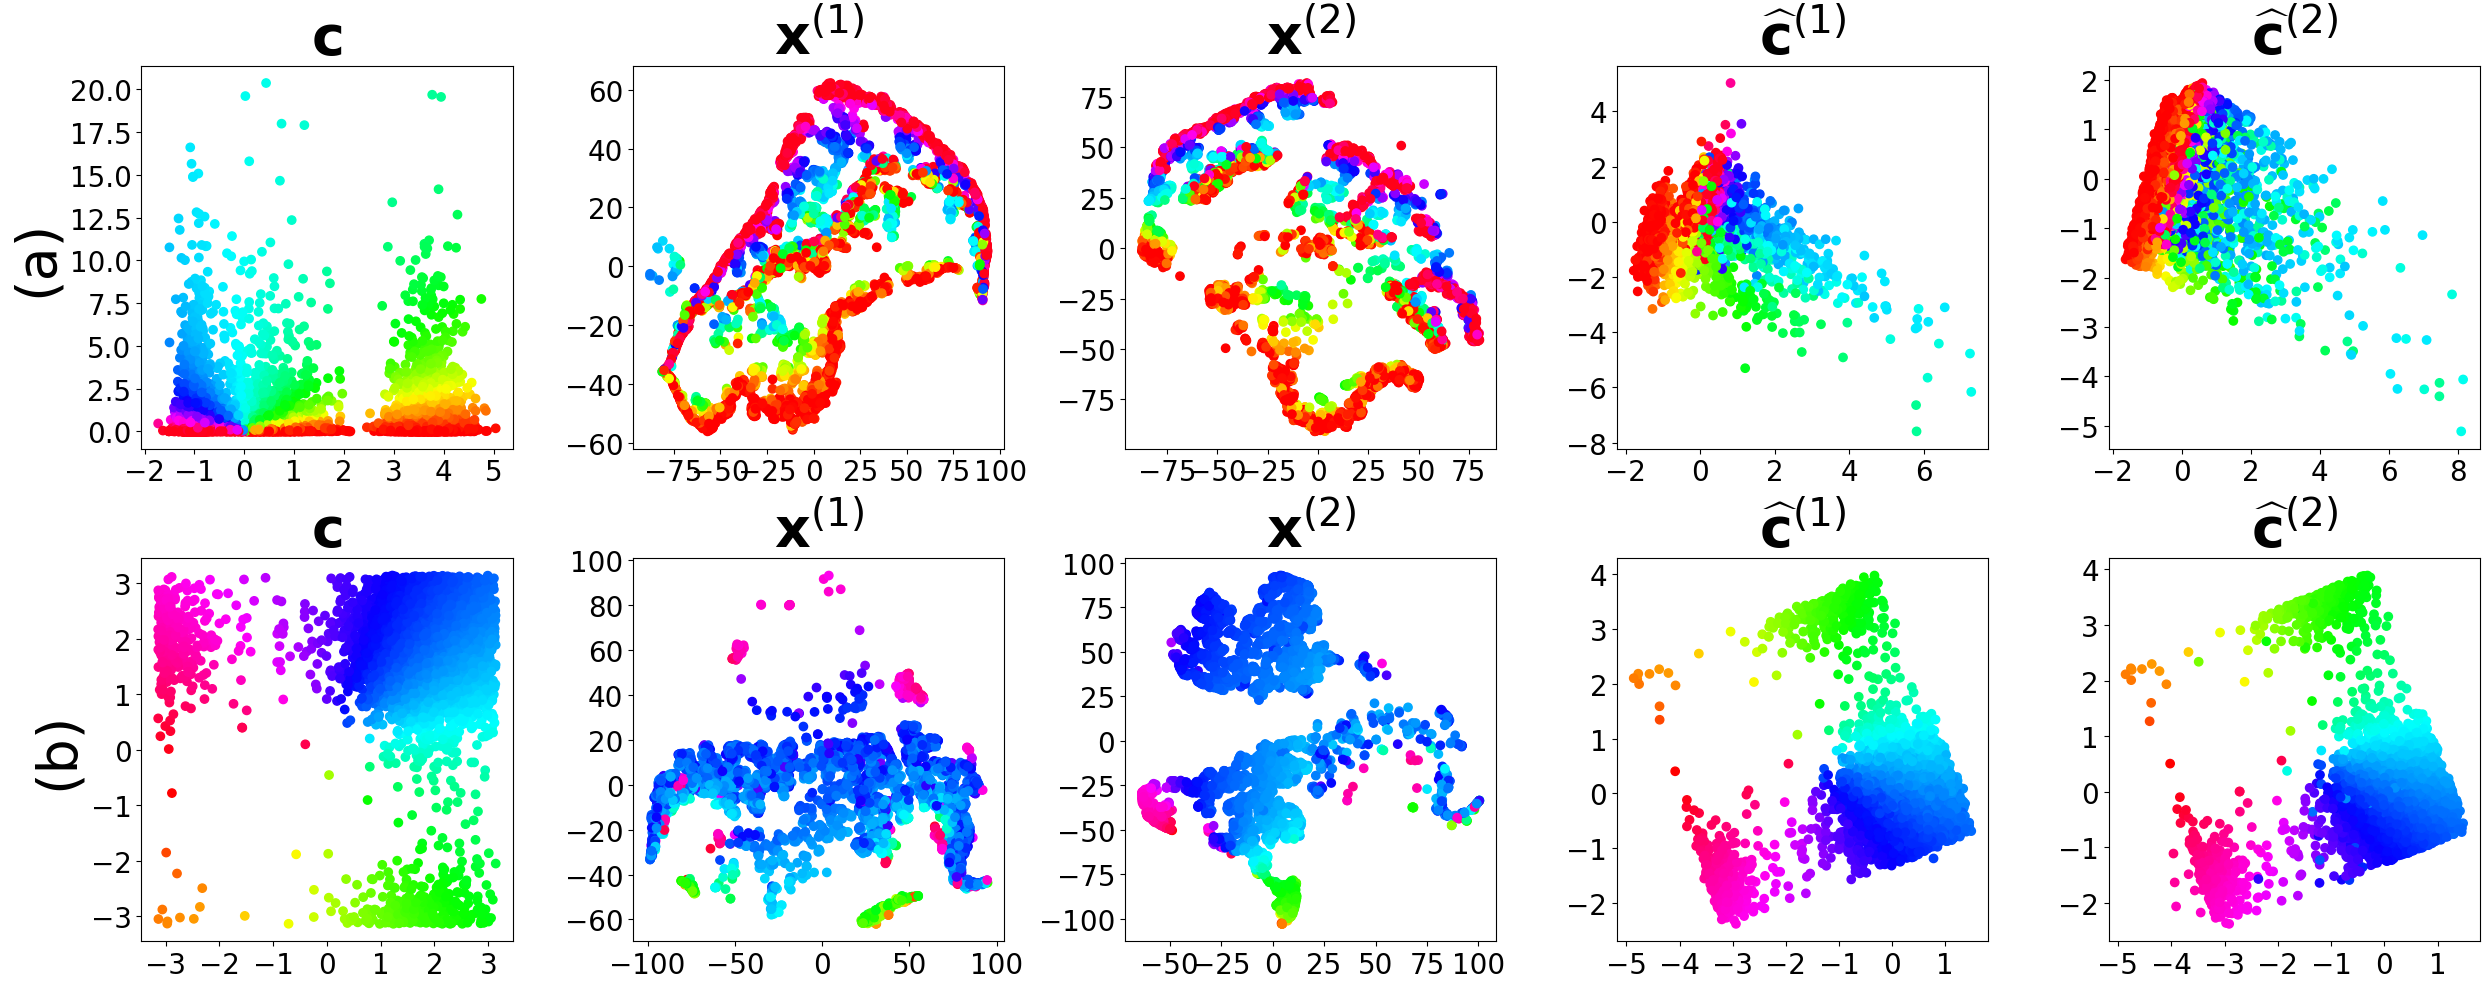

In [12]:
dims = [0, 1]
f1size = 20
f2size = 40

plt.close('all')
plt.figure(figsize=(25, 10))

colors_indep = np.arctan2(corig_indep[dims[1]], corig_indep[dims[0]])
plt.subplot(2,5,1)
plt.title(r"$\mathbf{c}$", fontsize=f2size)
plt.scatter(corig_indep[dims[0]], corig_indep[dims[1]], c=colors_indep, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)
plt.ylabel("(a)", fontsize=f2size)

plt.subplot(2,5,2)
plt.title(r"$\mathbf{x}^{(1)}$", fontsize=f2size)
plt.scatter(domain1_indep[dims[0]], domain1_indep[dims[1]], c=colors_indep, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(2,5,3)
plt.title(r"$\mathbf{x}^{(2)}$", fontsize=f2size)
plt.scatter(domain2_indep[dims[0]], domain2_indep[dims[1]], c=colors_indep, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(2,5,4)
plt.title(r"$\widehat{\mathbf{c}}^{(1)}$", fontsize=f2size)
plt.scatter(c1_indep[dims[0]], c1_indep[dims[1]], c=colors_indep, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(2,5,5)
plt.title(r"$\widehat{\mathbf{c}}^{(2)}$", fontsize=f2size)
plt.scatter(c2_indep[dims[0]], c2_indep[dims[1]], c=colors_indep, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

colors_rec = np.arctan2(corig_rec[dims[1]], corig_rec[dims[0]])

plt.subplot(2,5,6)
plt.title(r"$\mathbf{c}$", fontsize=f2size)
plt.scatter(corig_rec[dims[0]], corig_rec[dims[1]], c=colors_rec, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)
plt.ylabel("(b)", fontsize=f2size)

plt.subplot(2,5,7)
plt.title(r"$\mathbf{x}^{(1)}$", fontsize=f2size)
plt.scatter(domain1_rec[dims[0]], domain1_rec[dims[1]], c=colors_rec, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(2,5,8)
plt.title(r"$\mathbf{x}^{(2)}$", fontsize=f2size)
plt.scatter(domain2_rec[dims[0]], domain2_rec[dims[1]], c=colors_rec, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(2,5,9)
plt.title(r"$\widehat{\mathbf{c}}^{(1)}$", fontsize=f2size)
plt.scatter(c1_rec[dims[0]], c1_rec[dims[1]], c=colors_rec, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(2,5,10)
plt.title(r"$\widehat{\mathbf{c}}^{(2)}$", fontsize=f2size)
plt.scatter(c2_rec[dims[0]], c2_rec[dims[1]], c=colors_rec, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)



plt.tight_layout()
# plt.savefig("theorem1_result.pdf", dpi=150, bbox_inches='tight', format='pdf')

In [8]:
def run_simulations(signal_property, noise_property, data_dimensions, anchor_nums=0, random_seed=33333):
    import os
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    torch.autograd.set_detect_anomaly(True)

    torch.manual_seed(random_seed)
    cuda = torch.cuda.is_available()
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    
    data_generate = GenerateData(data_dimensions, opt.batch_size)
    mixer_property = {"mean": 0, "std": 1, "dist": "normal"}
    X_1, X_2, S, scir, C1, C2 = data_generate.generate_cca_data(signal_property, noise_property, mixer_property, normalize_mean=True)

    A1, A2 = data_generate.get_mixing_matrices()
    A1, A2 = A1.type(Tensor), A2.type(Tensor)

    X_1, X_2, S = X_1.type(Tensor), X_2.type(Tensor), S.type(Tensor)
    view1, view2 = data_generate.create_dataloader(X_1, X_2)

    z1 = CanonicalComponent(X_1, data_dimensions["D"], data_dimensions["M1"], data_dimensions["N"], Tensor)
    z2 = CanonicalComponent(X_2, data_dimensions["D"], data_dimensions["M2"], data_dimensions["N"], Tensor)
    f = WitnessFunction(data_dimensions["D"], opt.latent_dim)

    if anchor_nums > 0:
        max_anchor = X_1.shape[1]
        assert anchor_nums <= max_anchor, f"anchor_nums={anchor_nums} > available samples={max_anchor}"
        random_indices = np.random.choice(max_anchor, size=anchor_nums, replace=False)
        anchors1 = X_1[:, random_indices]
        anchors2 = X_2[:, random_indices]
        assert not torch.isnan(anchors1).any(), "anchors1 has NaN"
        assert not torch.isnan(anchors2).any(), "anchors2 has NaN"
    else:
        anc_loss = torch.tensor([0.0]).type(Tensor)
        anchors1, anchors2 = [], []

    if cuda:
        z1, z2, f = z1.cuda(), z2.cuda(), f.cuda()

    optimizer_z1 = torch.optim.Adam(z1.parameters(), lr=opt.alpha)
    optimizer_z2 = torch.optim.Adam(z2.parameters(), lr=opt.alpha)
    optimizer_f = torch.optim.Adam(f.parameters(), lr=opt.beta)

    lambdaa, lambda_anc = 0.1, 0.01
    batch_size = opt.batch_size
    n_epochs = data_dimensions["n_epochs"]
    loss_func = nn.BCEWithLogitsLoss()

    all_loss_f, all_loss_z, shared_component_dist = [], [], []
    
    for epoch in range(n_epochs - 1):
        avg_loss_z, avg_loss_f, avg_shared_dist = [], [], []
        noise_factor = 1.0 - (epoch / n_epochs)

        for i, (X1, X2) in enumerate(zip(view1, view2)):
            labels_true = (torch.ones((batch_size, 1)) - 0.2 * noise_factor * torch.rand((batch_size, 1))).type(Tensor)
            labels_false = (torch.zeros((batch_size, 1)) + 0.2 * noise_factor * torch.rand((batch_size, 1))).type(Tensor)

            optimizer_f.zero_grad()
            s_1, s_2 = z1(X1).T, z2(X2).T

            # 检查 s_2 是否出错
            if not torch.isfinite(s_2).all():
                print(f"[Epoch {epoch+1} Batch {i+1}] ❌ s_2 has NaN/Inf! s_2 stats: min={s_2.min().item():.2f}, max={s_2.max().item():.2f}")
                print(f"X2 stats: min={X2.min().item():.2f}, max={X2.max().item():.2f}")
                continue  # 跳过此 batch

            pred_1, pred_2 = f(s_1), f(s_2)
            if not torch.isfinite(pred_2).all():
                print(f"[Epoch {epoch+1} Batch {i+1}] ❌ f(s_2) has NaN/Inf! pred_2 stats: min={pred_2.min().item()}, max={pred_2.max().item()}")
                continue
            
            loss_f = loss_func(pred_1, labels_true) + loss_func(pred_2, labels_false)
            loss_f.backward()
            optimizer_f.step()

            for _ in range(1):
                optimizer_z1.zero_grad()
                s_1 = z1(X1).T
                loss_fz1 = loss_func(f(s_1), labels_false)
                reg_z1 = z1.id_loss() * data_dimensions["D"]
                anc_loss = torch.tensor([0.0]).type(Tensor)
                if anchor_nums > 0:
                    anc_loss = torch.norm(z1(anchors1.T) - z2(anchors2.T)) ** 2
                    if not torch.isfinite(anc_loss):
                        print(f"[Epoch {epoch+1}] ❌ Anchor loss NaN! Skipping batch.")
                        continue
                loss_z1 = loss_fz1 + lambdaa * reg_z1 + lambda_anc * anc_loss
                loss_z1.backward()
                optimizer_z1.step()

            for _ in range(1):
                optimizer_z2.zero_grad()
                s_2 = z2(X2).T
                loss_fz2 = loss_func(f(s_2), labels_true)
                reg_z2 = z2.id_loss() * data_dimensions["D"]
                anc_loss = torch.tensor([0.0]).type(Tensor)
                if anchor_nums > 0:
                    anc_loss = torch.norm(z1(anchors1.T) - z2(anchors2.T)) ** 2
                    if not torch.isfinite(anc_loss):
                        print(f"[Epoch {epoch+1}] ❌ Anchor loss NaN in z2 step! Skipping batch.")
                        continue
                loss_z2 = loss_fz2 + lambdaa * reg_z2 + lambda_anc * anc_loss
                loss_z2.backward()
                torch.nn.utils.clip_grad_norm_(z2.parameters(), max_norm=1.0)  # 防止爆炸
                optimizer_z2.step()

            with torch.no_grad():
                loss_z = loss_fz1 + loss_fz2
                s_x = z1(X_1.T).T
                s_y = z2(X_2.T).T
                dist_loss = torch.norm(s_x - s_y)
                if anchor_nums > 0 and anc_loss.item() > 1.5:
                    lambda_anc *= 2

            avg_loss_f.append(loss_f.item())
            avg_loss_z.append(loss_z.item())
            avg_shared_dist.append(dist_loss.item())

            print(f"[Epoch {epoch+1} - Batch {i+1}] z1: {loss_fz1.item():.3f}, z2: {loss_fz2.item():.3f}, anc: {anc_loss.item():.3f}, dist: {dist_loss.item():.3f}")

        all_loss_f.append(np.mean(avg_loss_f))
        all_loss_z.append(np.mean(avg_loss_z))
        shared_component_dist.append(np.mean(avg_shared_dist))

    return S, z1, z2, A1, A2, X_1, X_2, anchors1, anchors2, shared_component_dist


# Anchor point formulation

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [7]:
#Dimensions intializations M_q>=D, M_q >= (D+D1)cca_loss
data_dimensions_sym = {
    "N": 10**5, #Number of samples
    "D": 3, #shared component vector length
    "D1": 1, #Private component 1 vector length
    "D2": 1, #Private component 2 vector length
    "M1": 4, #(Number of rows)/(length of data) in actual data view1/ mixing matrix
    "M2": 4, #(Number of rows)/(length of data) in actual data view2/ mixing matrix
    "n_epochs":100
}

signal_property_sym = {"mean": 0, "std": 3, "dist": "laplace"} #these are parameters instead of mean and variance even though the variable is so
noise_property_sym = {"mean1": 1, "std1":3, "mean2": 0.5, "std2": 3, "dist1": "uniform", "dist2": "gamma"}

In [9]:
metadata_sym = run_simulations(signal_property_sym, noise_property_sym, data_dimensions_sym, random_seed = 77777)

Generating mixing  matrix.
Shared Component to Interference Ratio: -2.532
[Epoch 1 - Batch 1] z1: 0.698, z2: 0.706, anc: 0.000, dist: 14866.378
[Epoch 1 - Batch 2] z1: 0.728, z2: 0.698, anc: 0.000, dist: 14709.581
[Epoch 1 - Batch 3] z1: 0.754, z2: 0.691, anc: 0.000, dist: 14554.289
[Epoch 1 - Batch 4] z1: 0.787, z2: 0.686, anc: 0.000, dist: 14400.566
[Epoch 1 - Batch 5] z1: 0.808, z2: 0.680, anc: 0.000, dist: 14248.469
[Epoch 1 - Batch 6] z1: 0.823, z2: 0.677, anc: 0.000, dist: 14098.044
[Epoch 1 - Batch 7] z1: 0.868, z2: 0.672, anc: 0.000, dist: 13949.319
[Epoch 1 - Batch 8] z1: 0.900, z2: 0.670, anc: 0.000, dist: 13802.307
[Epoch 1 - Batch 9] z1: 0.938, z2: 0.670, anc: 0.000, dist: 13656.990
[Epoch 1 - Batch 10] z1: 0.949, z2: 0.671, anc: 0.000, dist: 13513.334
[Epoch 1 - Batch 11] z1: 0.985, z2: 0.677, anc: 0.000, dist: 13371.298
[Epoch 1 - Batch 12] z1: 1.012, z2: 0.676, anc: 0.000, dist: 13230.857
[Epoch 1 - Batch 13] z1: 1.029, z2: 0.680, anc: 0.000, dist: 13092.022
[Epoch 1 - B

In [10]:
metadata_anc2 = run_simulations(signal_property_sym, noise_property_sym, data_dimensions_sym, anchor_nums=1, random_seed = 777)


Generating mixing  matrix.
Shared Component to Interference Ratio: -2.480
[Epoch 1 - Batch 1] z1: 0.781, z2: 0.678, anc: 3229.552, dist: 21252.572
[Epoch 1 - Batch 2] z1: 0.814, z2: 0.697, anc: 3187.238, dist: 21091.463
[Epoch 1 - Batch 3] z1: 0.859, z2: 0.709, anc: 3145.197, dist: 20931.371
[Epoch 1 - Batch 4] z1: 0.882, z2: 0.726, anc: 3103.216, dist: 20773.898
[Epoch 1 - Batch 5] z1: 0.931, z2: 0.740, anc: 3060.767, dist: 20617.252
[Epoch 1 - Batch 6] z1: 0.972, z2: 0.762, anc: 3017.764, dist: 20461.617
[Epoch 1 - Batch 7] z1: 1.021, z2: 0.775, anc: 2975.199, dist: 20309.805
[Epoch 1 - Batch 8] z1: 1.071, z2: 0.803, anc: 2934.080, dist: 20163.273
[Epoch 1 - Batch 9] z1: 1.125, z2: 0.834, anc: 2894.754, dist: 20023.564
[Epoch 1 - Batch 10] z1: 1.177, z2: 0.847, anc: 2857.030, dist: 19890.871
[Epoch 1 - Batch 11] z1: 1.243, z2: 0.885, anc: 2820.466, dist: 19764.148
[Epoch 1 - Batch 12] z1: 1.315, z2: 0.944, anc: 2784.634, dist: 19642.129
[Epoch 1 - Batch 13] z1: 1.403, z2: 1.002, anc:

/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in BinaryCrossEntropyWithLogitsBackward0. Traceback of forward call that caused the error:
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/tornado/platform/asyncio.p

RuntimeError: Function 'BinaryCrossEntropyWithLogitsBackward0' returned nan values in its 0th output.

In [ ]:
#Might need to run with different seed if the GAN loss doesn't converge.
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# import torch
# torch.cuda.empty_cache()
metadata_anc3 = run_simulations(signal_property_sym, noise_property_sym, data_dimensions_sym, anchor_nums=3, random_seed = 777)

Generating mixing  matrix.
Shared Component to Interference Ratio: -2.480
[Epoch 1 - Batch 1] z1: 0.946, z2: 0.523, anc: 13045.354, dist: 21254.094
[Epoch 1 - Batch 2] z1: 0.952, z2: 0.528, anc: 12761.751, dist: 21088.326
[Epoch 1 - Batch 3] z1: 0.959, z2: 0.529, anc: 12477.682, dist: 20919.664
[Epoch 1 - Batch 4] z1: 0.964, z2: 0.534, anc: 12186.311, dist: 20753.529
[Epoch 1 - Batch 5] z1: 0.970, z2: 0.538, anc: 11889.456, dist: 20592.457
[Epoch 1 - Batch 6] z1: 0.976, z2: 0.543, anc: 11595.482, dist: 20436.486
[Epoch 1 - Batch 7] z1: 0.982, z2: 0.546, anc: 11308.654, dist: 20286.150
[Epoch 1 - Batch 8] z1: 0.990, z2: 0.551, anc: 11029.793, dist: 20141.375
[Epoch 1 - Batch 9] z1: 0.997, z2: 0.556, anc: 10758.086, dist: 20001.344
[Epoch 1 - Batch 10] z1: 1.003, z2: 0.559, anc: 10492.291, dist: 19864.953
[Epoch 1 - Batch 11] z1: 1.012, z2: 0.565, anc: 10231.327, dist: 19731.229
[Epoch 1 - Batch 12] z1: 1.017, z2: 0.573, anc: 9974.407, dist: 19599.438
[Epoch 1 - Batch 13] z1: 1.028, z2: 

/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in MmBackward0. Traceback of forward call that caused the error:
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/lgao638/anaconda3/envs/ca/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
   

RuntimeError: Function 'MmBackward0' returned nan values in its 0th output.

In [17]:
S, z1_sym, z2_sym, _, _, X_1, X_2, _, _, val_sym = metadata_sym
_, z1_anc2, z2_anc2, _, _, _, _, anc2_1, anc2_2, val_anc2 = metadata_anc2
_, z1_anc3, z2_anc3, _, _, _, _, anc3_1, anc3_2, val_anc3 = metadata_anc3

D = S.shape[0]

if D > 2:
    print("Applying TSNE to shared components. Dimension greater than 2.")
    s_x_sym = z1_sym(X_1.T).T.detach()
    s_y_sym = z2_sym(X_2.T).T.detach()

    s_x_anc2 = z1_anc2(X_1.T).T.detach()
    s_y_anc2 = z2_anc2(X_2.T).T.detach()

    s_x_anc3 = z1_anc3(X_1.T).T.detach()
    s_y_anc3 = z2_anc3(X_2.T).T.detach()
    
    corig = S[:,:visualize_dim].T.cpu().numpy()
    c1_sym = s_x_sym[:visualize_dim,].cpu().numpy()
    c2_sym = s_y_sym[:visualize_dim,].cpu().numpy()

    c1_anc2 = s_x_anc2[:visualize_dim,].cpu().numpy()
    c2_anc2 = s_y_anc2[:visualize_dim,].cpu().numpy()

    c1_anc3 = s_x_anc3[:visualize_dim,].cpu().numpy()
    c2_anc3 = s_y_anc3[:visualize_dim,].cpu().numpy()

    anc2_points  = z1_anc2(anc2_1.T).T.detach().cpu().numpy()
    anc3_points  = z1_anc3(anc3_1.T).T.detach().cpu().numpy()

    tsne_shared = TSNE(n_components=2)
    tsne_c = tsne_shared.fit_transform(np.vstack( (corig,  c1_sym, c2_sym, c1_anc2, c2_anc2, c1_anc3, c2_anc3, anc2_points, anc3_points)  ))
    corig = tsne_c[:visualize_dim, ].T
    c1_sym = tsne_c[visualize_dim: 2*visualize_dim, ].T
    c2_sym = tsne_c[2*visualize_dim: 3*visualize_dim, ].T
    c1_anc2 = tsne_c[3*visualize_dim: 4*visualize_dim, ].T
    c2_anc2 = tsne_c[4*visualize_dim: 5*visualize_dim, ].T
    c1_anc3 = tsne_c[5*visualize_dim: 6*visualize_dim, ].T
    c2_anc3 = tsne_c[6*visualize_dim:7*visualize_dim, ].T
    anc2_points = tsne_c[7*visualize_dim:7*visualize_dim+1 , ].T
    anc3_points = tsne_c[7*visualize_dim+1:, ].T
    
    print("Finished TSNE for shared components.")
    
    
else:
    s_x_sym = z1_sym(X_1.T).T.detach()
    s_y_sym = z2_sym(X_2.T).T.detach()

    s_x_anc2 = z1_anc2(X_1.T).T.detach()
    s_y_anc2 = z2_anc2(X_2.T).T.detach()

    s_x_anc3 = z1_anc3(X_1.T).T.detach()
    s_y_anc3 = z2_anc3(X_2.T).T.detach()
    
    corig = S[:,:visualize_dim].cpu().numpy()
    c1 = s_x_sym[:visualize_dim,].T.cpu().numpy()
    c2 = s_y_sym[:visualize_dim,].T.cpu().numpy()

    corig = S[:,:visualize_dim].cpu().numpy()
    c1_sym = s_x_sym[:visualize_dim,].T.cpu().numpy()
    c2_sym = s_y_sym[:visualize_dim,].T.cpu().numpy()

    c1_anc2 = s_x_anc2[:visualize_dim,].T.cpu().numpy()
    c2_anc2 = s_y_anc2[:visualize_dim,].T.cpu().numpy()

    c1_anc3 = s_x_anc3[:visualize_dim,].T.cpu().numpy()
    c2_anc3 = s_y_anc3[:visualize_dim,].T.cpu().numpy()


tsne = TSNE(n_components=2)
tsne_l = tsne.fit_transform(np.vstack( (X_1.T[:visualize_dim,].cpu().numpy(), X_2.T[:visualize_dim,].cpu().numpy()) ) )
domain1 = tsne_l[:visualize_dim, ].T
domain2 = tsne_l[visualize_dim:, ].T
print("Finished applying TSNE")


Applying TSNE to shared components. Dimension greater than 2.


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

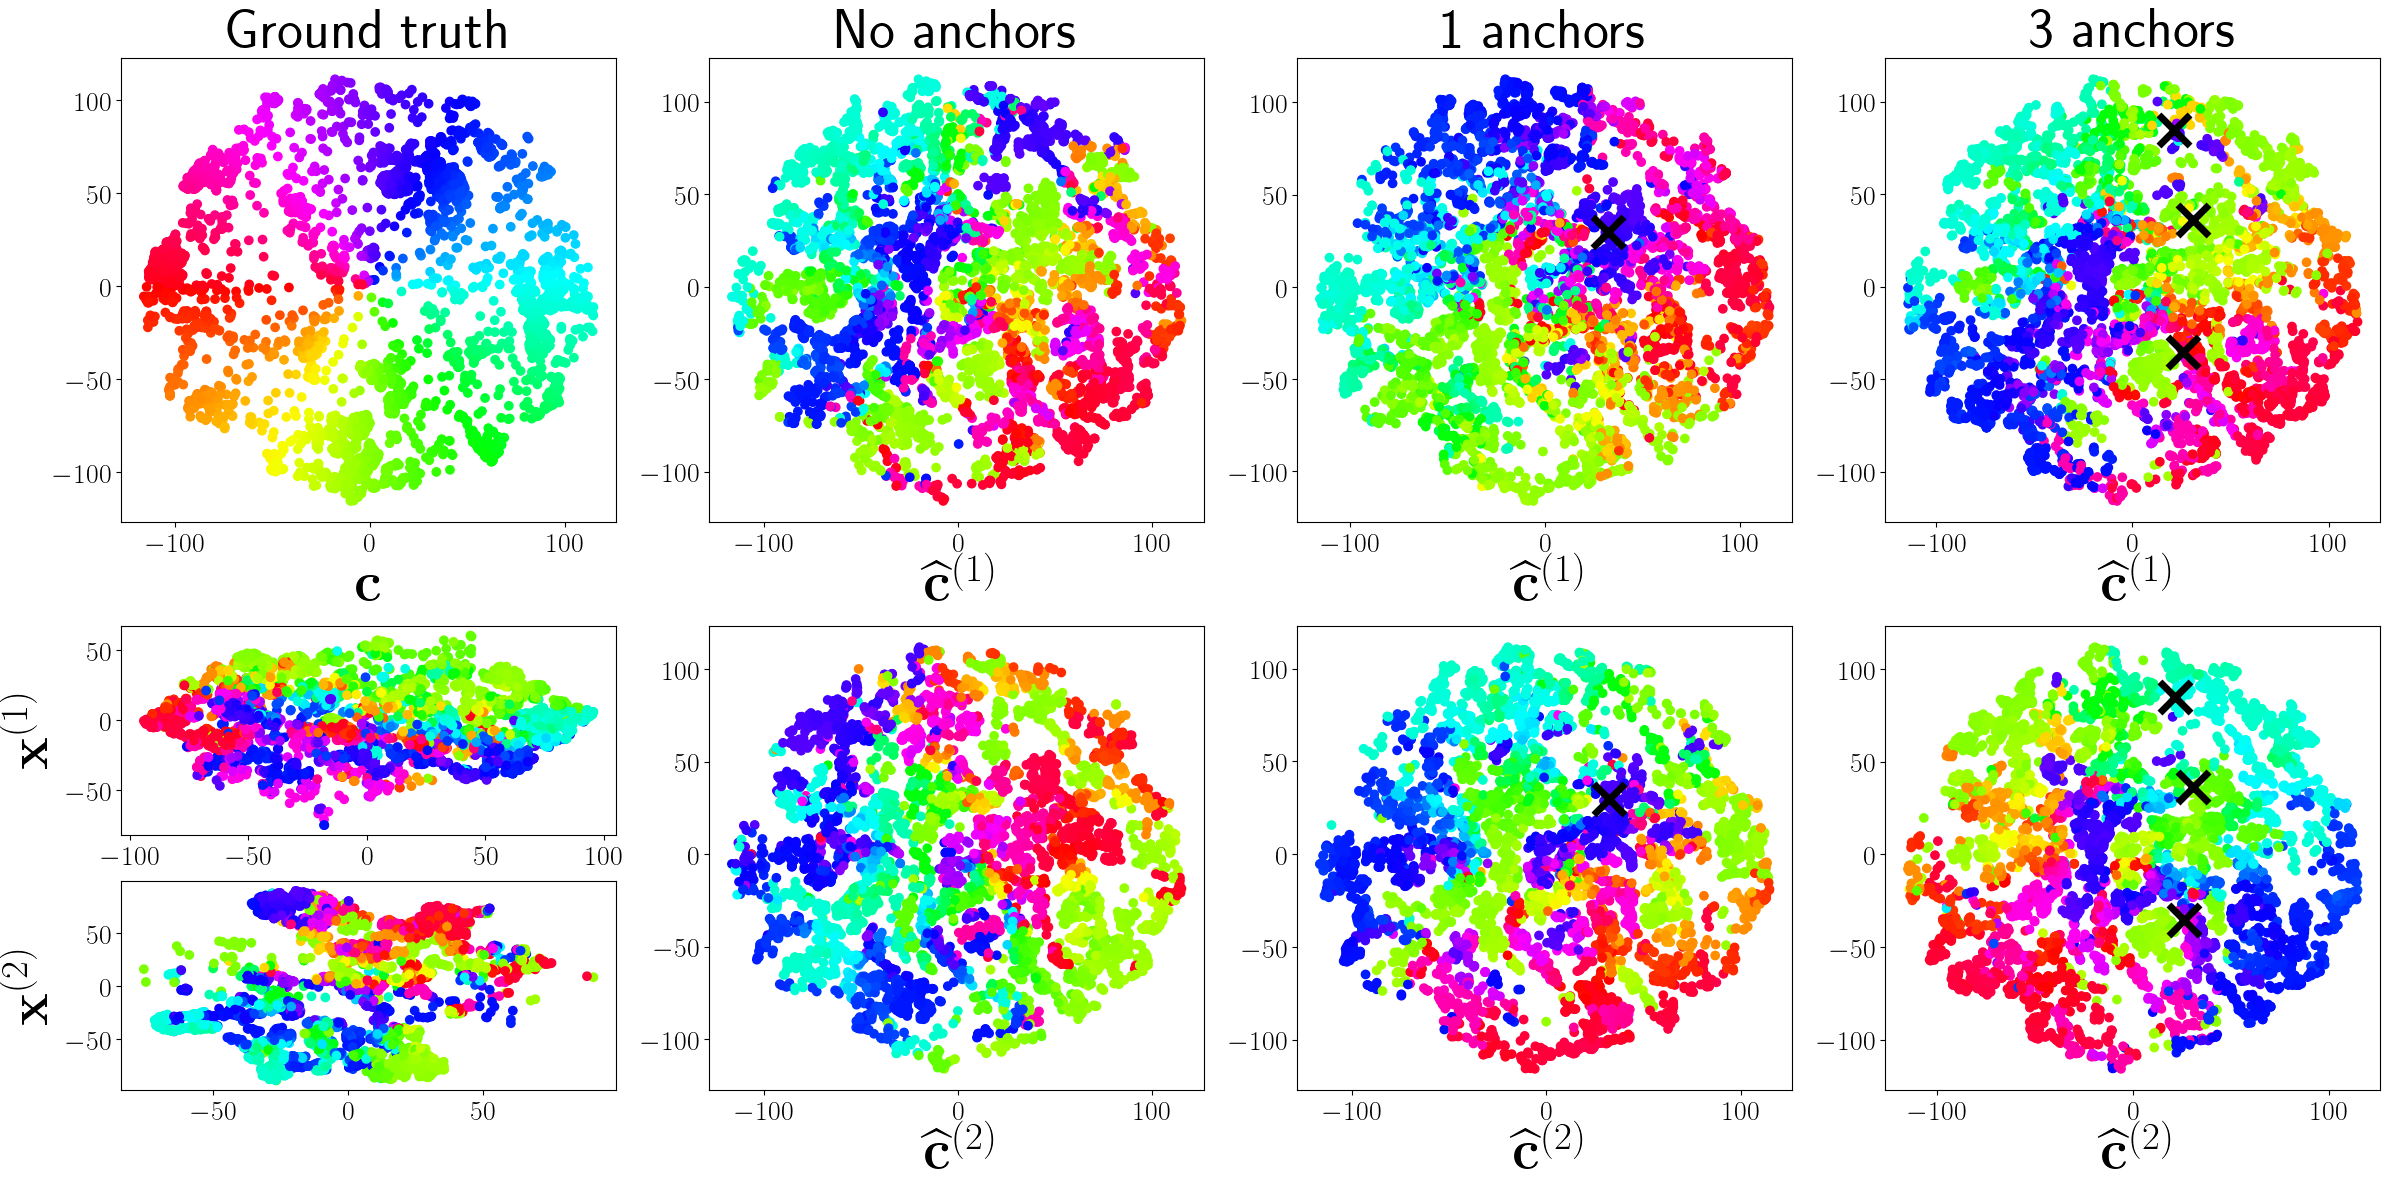

In [ ]:
#Sometimes the adversarial loss might not converge which might cause the issue below (See limitations section in the paper). Please ensure by convergence by changing learning rates.

import matplotlib.gridspec as gridspec
dims = [0, 1]
colors = np.arctan2(corig[dims[1]], corig[dims[0]])
f1size = 20
f2size = 40

plt.close('all')
fig = plt.figure(figsize=(24, 12))
marker_size = 500
marker_type = "x"
linewidth = 5

# Define the outer grid with 2 rows and 2 columns
outer_grid = gridspec.GridSpec(2, 4, figure=fig)

# Plot in the first subplot
ax1 = fig.add_subplot(outer_grid[0, 0])
ax1.scatter(corig[dims[0]], corig[dims[1]], c=colors, cmap='hsv')
ax1.set_xlabel(r"$\mathbf{c}$", fontsize=f2size)
ax1.tick_params(axis='both', which='major', labelsize=f1size)
ax1.set_title("Ground truth", fontsize=f2size)

# Define the inner grid for the second subplot
inner_grid = outer_grid[1, 0].subgridspec(2, 1)

# Plot in the upper half of the second subplot
ax2_1 = fig.add_subplot(inner_grid[0])
ax2_1.scatter(domain1[0], domain1[1], c=colors, cmap='hsv')
ax2_1.set_ylabel(r"$\mathbf{x}^{(1)}$", fontsize=f2size)
ax2_1.tick_params(axis='both', which='major', labelsize=f1size)

# Plot in the lower half of the second subplot
ax2_2 = fig.add_subplot(inner_grid[1])
ax2_2.scatter(domain2[0], domain2[1], c=colors, cmap='hsv')
ax2_2.set_ylabel(r"$\mathbf{x}^{(2)}$", fontsize=f2size)
ax2_2.tick_params(axis='both', which='major', labelsize=f1size)

# Plot in the third subplot
ax3 = fig.add_subplot(outer_grid[0, 1])
ax3.scatter(c1_sym[dims[0]], c1_sym[dims[1]], c=colors, cmap='hsv')
ax3.set_xlabel(r"$\widehat{\mathbf{c}}^{(1)}$", fontsize=f2size)
ax3.tick_params(axis='both', which='major', labelsize=f1size)
ax3.set_title("No anchors", fontsize=f2size)

# Plot in the fourth subplot
ax4 = fig.add_subplot(outer_grid[1, 1])
ax4.scatter(c2_sym[dims[0]], c2_sym[dims[1]], c=colors, cmap='hsv')
ax4.set_xlabel(r"$\widehat{\mathbf{c}}^{(2)}$", fontsize=f2size)
ax4.tick_params(axis='both', which='major', labelsize=f1size)

ax5 = fig.add_subplot(outer_grid[0, 2])
ax5.set_xlabel(r"$\widehat{\mathbf{c}}^{(1)}$", fontsize=f2size)
ax5.scatter(c1_anc2[dims[0]], c1_anc2[dims[1]], c=colors, cmap='hsv')
ax5.tick_params(axis='both', which='major', labelsize=f1size)
ax5.scatter(anc2_points[0], anc2_points[1], color='black', label='Anchor Point', s=marker_size, marker= marker_type, linewidths=linewidth)
ax5.set_title("1 anchors", fontsize=f2size)

ax6 = fig.add_subplot(outer_grid[1, 2])
ax6.set_xlabel(r"$\widehat{\mathbf{c}}^{(2)}$", fontsize=f2size)
ax6.scatter(c2_anc2[dims[0]], c2_anc2[dims[1]], c=colors, cmap='hsv')
ax6.tick_params(axis='both', which='major', labelsize=f1size)
ax6.scatter(anc2_points[0], anc2_points[1], color='black', label='Anchor Point', s=marker_size, marker= marker_type, linewidths=linewidth)


ax7 = fig.add_subplot(outer_grid[0, 3])
ax7.set_xlabel(r"$\widehat{\mathbf{c}}^{(1)}$", fontsize=f2size)
ax7.scatter(c1_anc3[dims[0]], c1_anc3[dims[1]], c=colors, cmap='hsv')
ax7.tick_params(axis='both', which='major', labelsize=f1size)
ax7.scatter(anc3_points[0], anc3_points[1], color='black', label='Anchor Point', s=marker_size, marker= marker_type, linewidths=linewidth)
ax7.set_title("3 anchors", fontsize=f2size)

ax8 = fig.add_subplot(outer_grid[1, 3])
ax8.set_xlabel(r"$\widehat{\mathbf{c}}^{(2)}$", fontsize=f2size)
ax8.scatter(c2_anc3[dims[0]], c2_anc3[dims[1]], c=colors, cmap='hsv')
ax8.tick_params(axis='both', which='major', labelsize=f1size)
ax8.scatter(anc3_points[0], anc3_points[1], color='black', label='Anchor Point', s=marker_size, marker= marker_type, linewidths=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig("theorem5_result.pdf")
# Show the plot
plt.show()


# Success rate of GAN convergence

In [10]:
sample_seeds = np.random.choice(range(1, 100000), 5, replace=False)

In [13]:
sample_seeds

array([60203, 96537, 44659, 42538, 19194])

In [11]:
#Dimensions intializations M_q>=D, M_q >= (D+D1)cca_loss
data_dimensions_sym = {
    "N": 10**5, #Number of samples
    "D": 3, #shared component vector length
    "D1": 1, #Private component 1 vector length
    "D2": 1, #Private component 2 vector length
    "M1": 4, #(Number of rows)/(length of data) in actual data view1/ mixing matrix
    "M2": 4, #(Number of rows)/(length of data) in actual data view2/ mixing matrix
    "n_epochs":50
}

signal_property_sym = {"mean": 0, "std": 3, "dist": "laplace"} #these are parameters instead of mean and variance even though the variable is so
noise_property_sym = {"mean1": 1, "std1":3, "mean2": 0.5, "std2": 3, "dist1": "uniform", "dist2": "gamma"}

In [14]:
success = 0
for seeds in sample_seeds:
    metadata_anc3 = run_simulations(signal_property_sym, noise_property_sym, data_dimensions_sym, anchor_nums=3, random_seed = seeds)
    if metadata_anc3[-1][-1] < 100:
        success += 1
print(f"{success} numbers of success out of 5")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
